# Introduction

This notebook is for the major project submission for COMP8220, on the FER-2013 dataset.  It contains the following sections:

*   The loading of images and creation of sets
*   My best conventional Machine Learning model (SVM, accuracy 64%)
*   Other conventional Machine Learning model that are less efficient, and the importance of features
*   My best Deep Learning model (CNN, accuracy 67%)
*   Other Deep Learning model that are less efficient
*   A conclusion

The aim of the project is to create from scratch different models of facial emotion recognition. These 7 emotions are classified: 'angry', 'disgust', 'fear', 'happy', 'sad', 'surprise' and 'neutral'.

In the end, the CNN models that performed a 67% on a private test set ranked #7 out of 32 people.


To run the code, you will need to download the .npy files (or images) and change the path directory to your own.

# import

In [2]:
from google.colab import drive
from os.path import join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skimage.feature import hog
import imgaug as ia
import imgaug.augmenters as iaa
from joblib import dump, load

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model


## Load the provided data and print them

In this project, two different data set are used for training. The first one, in the '/content/drive/My Drive/Colab Notebooks/Project/data' directory, is the one provided by the professor of the unit. The second one, stored in '/content/drive/My Drive/Colab Notebooks/Project/data/full_data/archive/', is a one a made from images of the FER-2013 dataset.
Testing is made on a personal test set, made from the training set 1.
Result of test on the Public and Private set have been submit on Kaggle.


In [ ]:
# Load provided data from google drive
drive.mount('/content/drive/')

image_size = 48
EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

dataset_directory = '/content/drive/My Drive/Colab Notebooks/Project/data'

images_train = np.load(join(dataset_directory, 'Training_data_images.npy'))
labels_train = np.load(join(dataset_directory, 'Training_data_labels.npy'))

images_test_public = np.load(join(dataset_directory, 'PublicTest_data_images.npy'))
images_test_private = np.load(join(dataset_directory, 'PrivateTest_data_images.npy'))

# Reshapping data
images_train = images_train.reshape([-1, image_size, image_size])
images_test_public = images_test_public.reshape([-1, image_size, image_size])
images_test_private = images_test_private.reshape([-1, image_size, image_size])

print(images_train.shape) #output : (9328, 48, 48)
print(labels_train.shape)
print(images_test_public.shape)
print(images_test_private.shape)

Mounted at /content/drive/
(9328, 48, 48)
(9328,)
(1136, 48, 48)
(1153, 48, 48)


In [ ]:
# text access to image and label
sample = 1
print("Image pixels are: ", images_train[sample])
print("Label is: ", labels_train[sample])
print("Emotion is:", EMOTIONS[labels_train[sample]])

Image pixels are:  [[0.77647059 0.77647059 0.77647059 ... 0.78039216 0.78039216 0.78431373]
 [0.         0.         0.         ... 0.07843137 0.06666667 0.78039216]
 [0.00392157 0.         0.         ... 0.09019608 0.08627451 0.78039216]
 ...
 [0.         0.         0.         ... 0.1254902  0.10196078 0.78039216]
 [0.         0.         0.         ... 0.12156863 0.10196078 0.78039216]
 [0.         0.         0.         ... 0.11372549 0.10196078 0.78039216]]
Label is:  6
Emotion is: neutral


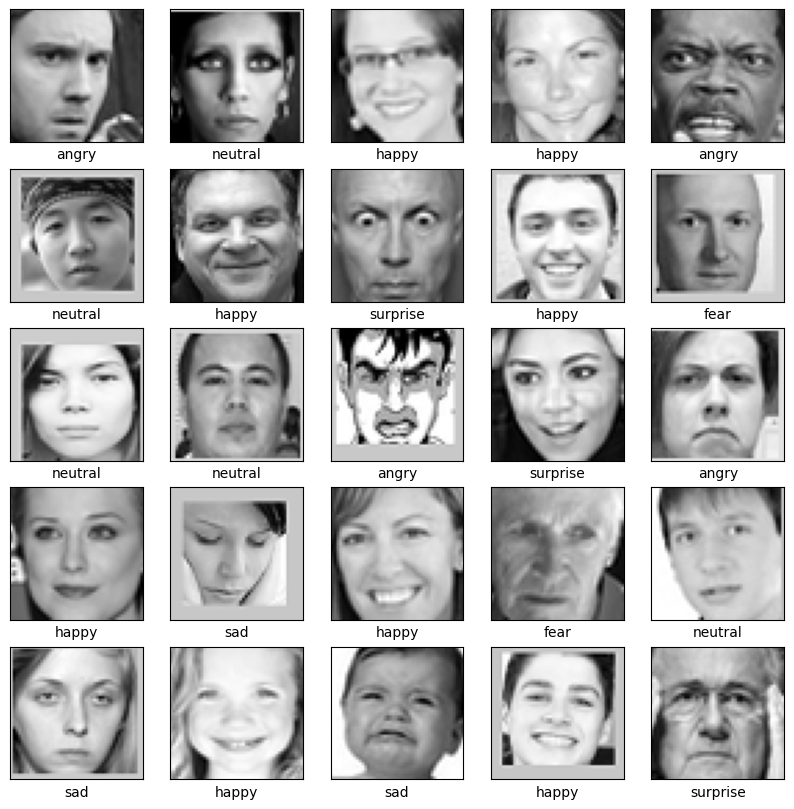

In [ ]:
# Visualisation of the provided trian set

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_train[i], cmap='gray')
    plt.xlabel( EMOTIONS[ labels_train[i] ] )
plt.show()

## Creation of an other Data set : the full one

To create this data set, I used the 30.000 jpeg images of the training FER-2013 set. The following code load images, create .npy files and reshape datas. When donloaded, images are sorted by emotion.

As files are already created, the code to make them is commented.

In [ ]:
import cv2
import os
dataset_train_full_directory = '/content/drive/My Drive/Colab Notebooks/Project/data/full_data/archive/train'
dataset_test_full_directory = '/content/drive/My Drive/Colab Notebooks/Project/data/full_data/archive/test'


In [ ]:
# Function to load all the jpeg images
'''
def jpeg_in_array_emotions (path_directory):
  i = 0
  images = []
  labels = []

  for i, emotion in enumerate(EMOTIONS):
    emotion_folder_path = join(path_directory, emotion)
    # List the image files in the subfolder
    image_files = os.listdir(emotion_folder_path)
    for image_file in image_files:
      #read the image in jpeg format
      image = cv2.imread(join(emotion_folder_path, image_file))
      images.append(image)
      labels.append(i)

  return images, labels
  '''

'\ndef jpeg_in_array_emotions (path_directory):\n  i = 0\n  images = []\n  labels = []\n\n  for i, emotion in enumerate(EMOTIONS):\n    emotion_folder_path = join(path_directory, emotion)\n    # List the image files in the subfolder\n    image_files = os.listdir(emotion_folder_path)\n    for image_file in image_files:\n      #read the image in jpeg format\n      image = cv2.imread(join(emotion_folder_path, image_file))\n      images.append(image)\n      labels.append(i)\n\n  return images, labels\n  '

In [ ]:
# Call the loading images function
'''
# creation of images and labels for train and test set
raw_images_train_full, raw_labels_train_full = jpeg_in_array_emotions(dataset_train_full_directory)
raw_images_test_full, raw_labels_test_full = jpeg_in_array_emotions(dataset_test_full_directory)
print(len(raw_images_train_full))
'''

28709


In [ ]:
# Creation of .npy files and reshaping data
'''
# Convert in array format
array_images_train_full = np.array(raw_images_train_full)
array_images_test_full = np.array(raw_images_test_full)
array_labels_train_full = np.array(raw_labels_train_full)
array_labels_test_full = np.array(raw_labels_test_full)

# Convertion of data in gray_scale
array_gray_images_train_full = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in array_images_train_full])
array_gray_images_test_full = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in array_images_test_full])

array_images_train_full = np.array([])
array_images_test_full = np.array([])

# Reshaping data
array_images_train_full = array_gray_images_train_full.reshape(-1, image_size, image_size)
array_images_test_full = array_gray_images_test_full.reshape(-1, image_size, image_size)

array_images_train_full = array_images_train_full / 255.0
array_images_test_full = array_images_test_full / 255.0

# Shuffle the data by creatin indices to shuffle images and labels the same way
shuffled_indices_train = np.random.permutation(len(array_images_train_full))
shuffled_indices_test = np.random.permutation(len(array_images_test_full))
array_images_train_full = array_images_train_full[shuffled_indices_train]
array_images_test_full = array_images_test_full[shuffled_indices_test]
array_labels_train_full = array_labels_train_full[shuffled_indices_train]
array_labels_test_full = array_labels_test_full[shuffled_indices_test]

# Save in .npy format
np.save(join(dataset_train_full_directory, 'images_train_full.npy'), array_images_train_full)
np.save(join(dataset_test_full_directory, 'images_test_full.npy'), array_images_test_full)
np.save(join(dataset_train_full_directory, 'labels_train_full.npy'), array_labels_train_full)
np.save(join(dataset_test_full_directory, 'labels_test_full.npy'), array_labels_test_full)

print("Ensemble de données sauvegardé au format .npy.")
'''

## Load the full data set from .npy files

(28709, 48, 48)
(7178, 48, 48)
(28709,)
(7178,)
[[0.24705882 0.24705882 0.19215686 ... 0.20784314 0.16078431 0.09803922]
 [0.29411765 0.21176471 0.18039216 ... 0.18431373 0.18039216 0.10588235]
 [0.28235294 0.20392157 0.18823529 ... 0.1372549  0.19607843 0.1372549 ]
 ...
 [0.6745098  0.64313725 0.63529412 ... 0.18823529 0.13333333 0.04705882]
 [0.70196078 0.68235294 0.65882353 ... 0.17254902 0.12941176 0.04705882]
 [0.69019608 0.69803922 0.69411765 ... 0.18039216 0.13333333 0.05490196]]


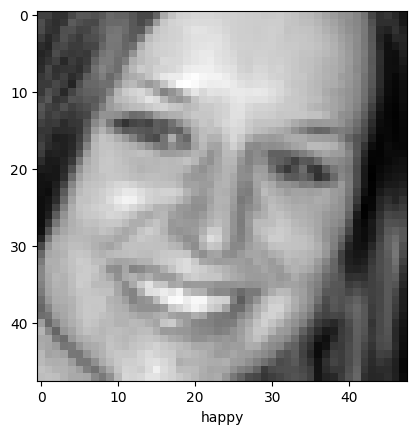

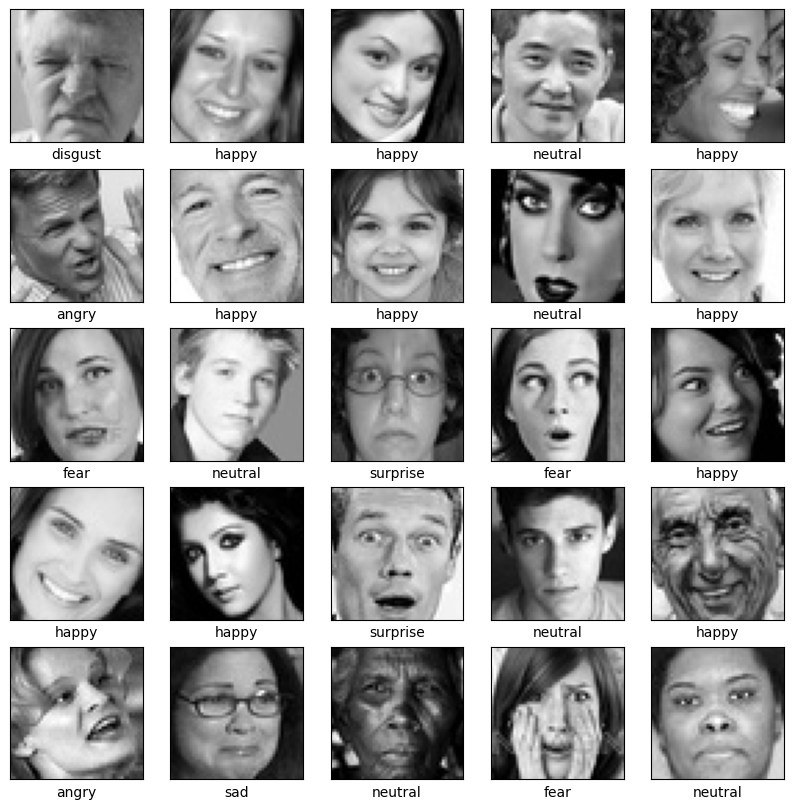

In [ ]:
# Load the full data from .npy files
images_train_full = np.load(join(dataset_train_full_directory, 'images_train_full.npy'), allow_pickle=True)
images_test_full = np.load(join(dataset_test_full_directory, 'images_test_full.npy'), allow_pickle=True)
labels_train_full = np.load(join(dataset_train_full_directory, 'labels_train_full.npy'), allow_pickle=True)
labels_test_full = np.load(join(dataset_test_full_directory, 'labels_test_full.npy'), allow_pickle=True)

print(images_train_full.shape)
print(images_test_full.shape)
print(labels_train_full.shape)
print(labels_test_full.shape)

# Print images to check labels are correctly associated with images
print(images_train_full[1])
plt.imshow(images_train_full[1], cmap='gray')
plt.xlabel( EMOTIONS[ labels_train_full[1] ] )

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_train_full[i], cmap='gray')
    plt.xlabel( EMOTIONS[ labels_train_full[i] ] )
plt.show()


In [ ]:
# Function to print the proportion of each emotion in a set

def proportions_set (labels_set) :
  # Count the occurrences of each emotion
  emotion_counts = {emotion: np.sum(labels_set == index) for index, emotion in enumerate(EMOTIONS)}

  # Calculate the total number of samples
  total_samples = len(labels_set)

  # Calculate the proportion of each emotion
  emotion_proportions = {emotion: count / total_samples for emotion, count in emotion_counts.items()}

  # Print the number of each emotion and their proportions
  for emotion, count in emotion_counts.items():
      proportion = emotion_proportions[emotion]
      print(f"Emotion: {emotion}, Count: {count}, Proportion: {proportion:.2%}")

  print(" ")

In [ ]:
proportions_set(labels_train)

Emotion: angry, Count: 1266, Proportion: 13.57%
Emotion: disgusted, Count: 211, Proportion: 2.26%
Emotion: fearful, Count: 1107, Proportion: 11.87%
Emotion: happy, Count: 2736, Proportion: 29.33%
Emotion: sad, Count: 1043, Proportion: 11.18%
Emotion: surprised, Count: 1052, Proportion: 11.28%
Emotion: neutral, Count: 1913, Proportion: 20.51%
 


Shape of Smaller Images Train: (700, 48, 48)
Shape of Smaller Labels Train: (700,)
Emotion: angry, Count: 100, Proportion: 14.29%
Emotion: disgusted, Count: 100, Proportion: 14.29%
Emotion: fearful, Count: 100, Proportion: 14.29%
Emotion: happy, Count: 100, Proportion: 14.29%
Emotion: sad, Count: 100, Proportion: 14.29%
Emotion: surprised, Count: 100, Proportion: 14.29%
Emotion: neutral, Count: 100, Proportion: 14.29%
 
None


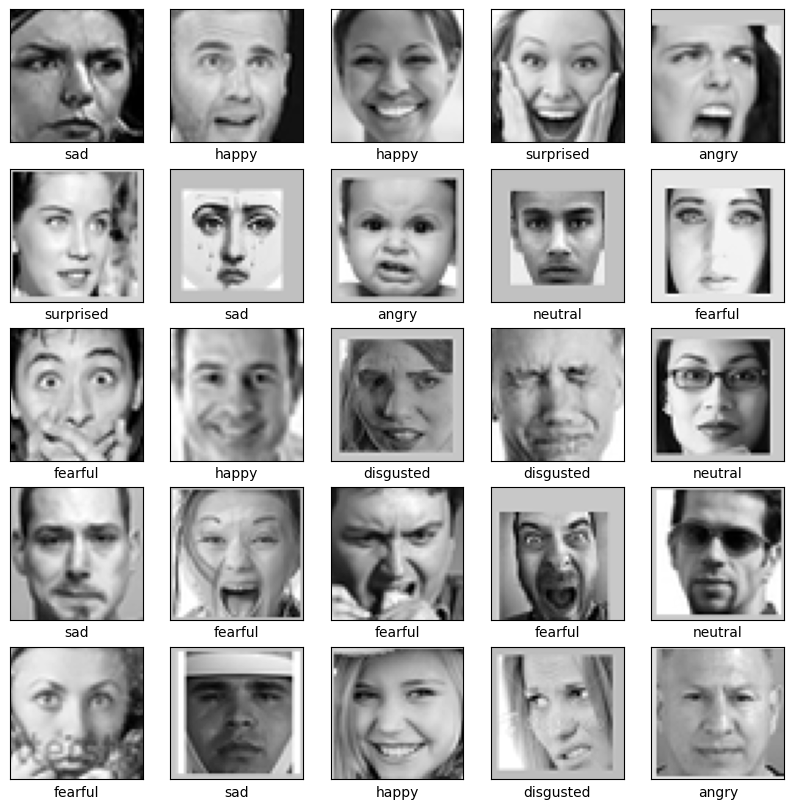

In [ ]:
# Code to create an equalitarian balance set of each emotion.
# This set was used but is no longer use by models, du to it poor result

# Create a balance array of images of each emotions, and remove these images from the original dataset : creation of a new test and train set
'''
# Initialize variables to store the smaller dataset
smaller_images_train = []
smaller_labels_train = []

# Define the desired number of samples per emotion
samples_per_emotion = 100

# Iterate through each emotion and select 100 samples randomly
for emotion_index, emotion_name in enumerate(EMOTIONS):
    # Find indices of samples with the current emotion
    emotion_indices = np.where(labels_train == emotion_index)[0]

    # Randomly select 100 samples if available
    if len(emotion_indices) >= samples_per_emotion:
        selected_indices = np.random.choice(emotion_indices, samples_per_emotion, replace=False)
        smaller_images_train.extend(images_train[selected_indices])
        smaller_labels_train.extend(labels_train[selected_indices])

        images_train = np.delete(images_train, selected_indices, axis=0)
        labels_train = np.delete(labels_train, selected_indices)

# Convert the lists to NumPy arrays
smaller_images_train = np.array(smaller_images_train)
smaller_labels_train = np.array(smaller_labels_train)

random_indices = np.arange(len(smaller_labels_train))
np.random.shuffle(random_indices)
smaller_images_train = smaller_images_train[random_indices]
smaller_labels_train = smaller_labels_train[random_indices]

# Verify the shape of the smaller dataset
print("Shape of Smaller Images Train:", smaller_images_train.shape)
print("Shape of Smaller Labels Train:", smaller_labels_train.shape)

print(proportions_set(smaller_labels_train))

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(smaller_images_train[i], cmap='gray')
    plt.xlabel( EMOTIONS[ smaller_labels_train[i] ] )
plt.show()
'''

## Creation of training and test set

In [ ]:
# images_val (and labels_val) are random 20% of images_train (and labels_train)

# creation of a validation set
images_train, images_val, labels_train, labels_val = train_test_split(images_train, labels_train, test_size=0.2, random_state=42)

# creation of a test set
images_train, images_test, labels_train, labels_test = train_test_split(images_train, labels_train, test_size=0.2, random_state=42)

In [ ]:
proportions_set(labels_train)
print(len(images_train))
print(len(labels_train))

Emotion: angry, Count: 808, Proportion: 13.54%
Emotion: disgust, Count: 131, Proportion: 2.19%
Emotion: fear, Count: 717, Proportion: 12.01%
Emotion: happy, Count: 1719, Proportion: 28.80%
Emotion: sad, Count: 675, Proportion: 11.31%
Emotion: surprise, Count: 674, Proportion: 11.29%
Emotion: neutral, Count: 1245, Proportion: 20.86%
 
5969
5969


In [ ]:
# Ceration of a second and a thrid training set by splitting the full data set

#images_train_full_1 = 75% of images_train_full
#images_train_full_2 = 25% of images_train_full

images_train_full_1, images_train_full_2, labels_train_full_1, labels_train_full_2 = train_test_split(images_train_full, labels_train_full, test_size=0.25, random_state=42)


Emotion: angry, Count: 1862, Proportion: 14.16%
Emotion: disgust, Count: 234, Proportion: 1.78%
Emotion: fear, Count: 1753, Proportion: 13.33%
Emotion: happy, Count: 3530, Proportion: 26.85%
Emotion: sad, Count: 1865, Proportion: 14.19%
Emotion: surprise, Count: 1450, Proportion: 11.03%
Emotion: neutral, Count: 2453, Proportion: 18.66%
 
13147


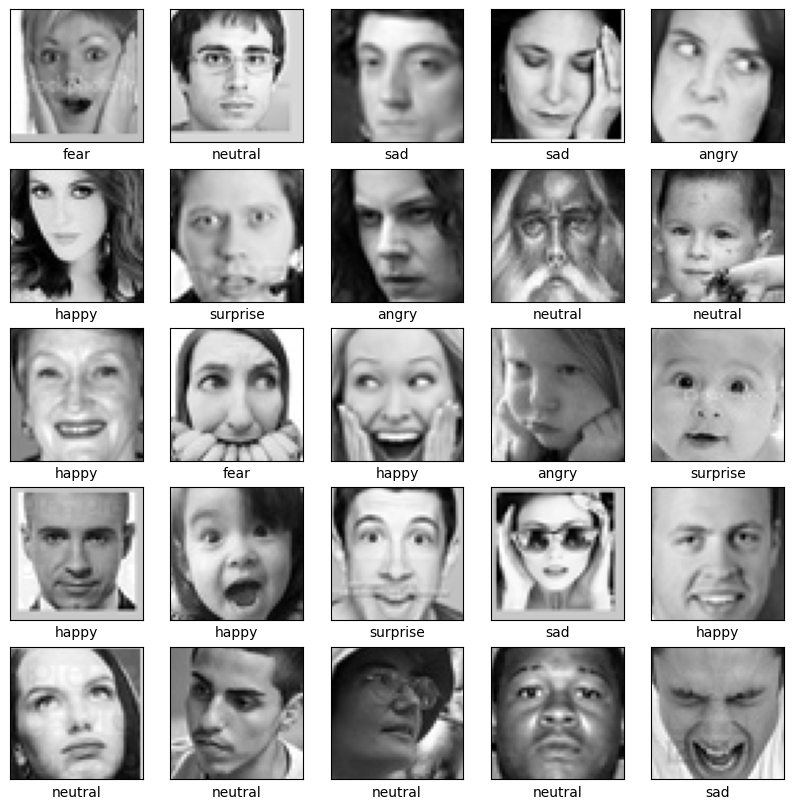

In [ ]:
# Creation of a mix trainig set, which is a concatenation of the provided data set and the smaller one of the full one
# It coantains 13147 images.

images_train_mix = np.concatenate((images_train_full_2, images_train))
labels_train_mix = np.concatenate((labels_train_full_2, labels_train))

shuffled_indices_train_mix = np.random.permutation(len(images_train_mix))
images_train_mix = images_train_mix[shuffled_indices_train_mix]
labels_train_mix = labels_train_mix[shuffled_indices_train_mix]

proportions_set(labels_train_mix)
print(len(images_train_mix))

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_train_mix[i], cmap='gray')
    plt.xlabel( EMOTIONS[ labels_train_mix[i] ] )
plt.show()

In [ ]:
print(images_train.shape)
print(labels_train.shape)
print(images_test.shape)
print(labels_test.shape)
print(images_train_mix.shape)
print(labels_train_mix.shape)

(5969, 48, 48)
(5969,)
(1493, 48, 48)
(1493,)
(13147, 48, 48)
(13147,)


# Conventional ML Model

The final model that produced the best-performing predictions for the Kaggle submission (accuracy 64%) was an SVM with a polynomial kernel.  The features were a kernel set on "poly", degree on 3, coef0 on 1 and C on 1.
Data augmentation, HOG features and a bigger training set than the provided one were used.

In [ ]:
#proportions_set(smaller_labels_train)
proportions_set(labels_val)
proportions_set(labels_train)

Emotion: angry, Count: 252, Proportion: 13.50%
Emotion: disgust, Count: 34, Proportion: 1.82%
Emotion: fear, Count: 219, Proportion: 11.74%
Emotion: happy, Count: 554, Proportion: 29.69%
Emotion: sad, Count: 217, Proportion: 11.63%
Emotion: surprise, Count: 213, Proportion: 11.41%
Emotion: neutral, Count: 377, Proportion: 20.20%
 
Emotion: angry, Count: 808, Proportion: 13.54%
Emotion: disgust, Count: 131, Proportion: 2.19%
Emotion: fear, Count: 717, Proportion: 12.01%
Emotion: happy, Count: 1719, Proportion: 28.80%
Emotion: sad, Count: 675, Proportion: 11.31%
Emotion: surprise, Count: 674, Proportion: 11.29%
Emotion: neutral, Count: 1245, Proportion: 20.86%
 


In [ ]:
def extract_hog_features(image):
    # Paramètres HOG
    pixels_per_cell = (8, 8)
    cells_per_block = (2, 2)
    feature_vector, _ = hog(image, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualize=True)
    return feature_vector

In [ ]:
# Process of data augmentation for SVM
sequential = iaa.Sequential([
    iaa.Affine(rotate=(-10, 10)),
    iaa.Fliplr(0.5),
    iaa.Affine(scale=(0.9, 1.3))
])

In [ ]:
# SVC training on mix training data and with HOG features

training_images = images_train_mix
training_labels = labels_train_mix
test_images = images_test
test_labels = labels_test

# Apply data augmentation on training set
all_images = []
for image in training_images:
    augmented_images = sequential.augment_images([image])
    all_images.extend(augmented_images)
all_images = np.array(all_images)

all_images = np.concatenate((training_images, all_images), axis = 0)
all_labels_train = np.concatenate((training_labels, training_labels), axis = 0)

# Extract HOG features for training images
hog_features_train = [extract_hog_features(image) for image in all_images]
# Extract HOG features for test images
hog_features_test = [extract_hog_features(image) for image in test_images]

# Model SVM Classifier
poly_kernel_svm_clf = Pipeline([
  ("scaler", StandardScaler()),
  ("svm_clf", SVC(kernel = "poly", degree = 3, coef0 = 1, C = 1))
])

poly_kernel_svm_clf.fit(hog_features_train, all_labels_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=1, coef0=1, kernel='poly'))])

In [ ]:
# Saving the model
dump(poly_kernel_svm_clf, '/content/drive/My Drive/Colab Notebooks/Project/model/SVC_HOG_MIX_LocalTest_model_2.joblib')

['/content/drive/My Drive/Colab Notebooks/Project/model/SVC_HOG_MIX_LocalTest_model_2.joblib']

In [ ]:
loaded_poly_kernel_svm_clf = load('/content/drive/My Drive/Colab Notebooks/Project/model/SVC_HOG_MIX_LocalTest_model_2.joblib')

# Compute predictions
predictions = loaded_poly_kernel_svm_clf.predict(hog_features_test)

# Evaluate the model's performance
accuracy = accuracy_score(test_labels, predictions)
report = classification_report(test_labels, predictions)
confusion = confusion_matrix(test_labels, predictions)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", confusion)
# Accuracy is 0.64 with (3 1 1) for the SVC kernel model. It has the same accuracy with (4, 1, 5) as parameters

Accuracy: 0.6430006697923644
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.50      0.52       206
           1       0.76      0.48      0.59        46
           2       0.46      0.46      0.46       171
           3       0.83      0.86      0.84       463
           4       0.44      0.42      0.43       151
           5       0.70      0.69      0.70       165
           6       0.57      0.63      0.60       291

    accuracy                           0.64      1493
   macro avg       0.61      0.58      0.59      1493
weighted avg       0.64      0.64      0.64      1493

Confusion Matrix:
 [[103   1  34  11  18   8  31]
 [ 14  22   3   3   4   0   0]
 [ 16   0  79  15  16  24  21]
 [ 13   4   6 397  10   2  31]
 [ 14   1  16  10  63   4  43]
 [  3   0  19  15   4 114  10]
 [ 28   1  15  27  28  10 182]]


In [ ]:
# The same model but with HOG features extraction on the private set, that have been submit on Kaggle.

training_images = images_train_mix
training_labels = labels_train_mix
test_images = images_test_private

all_images = []
for image in training_images:
    augmented_images = sequential.augment_images([image])
    all_images.extend(augmented_images)
all_images = np.array(all_images)

all_images = np.concatenate((training_images, all_images), axis = 0)
all_labels_train = np.concatenate((training_labels, training_labels), axis = 0)

# Extract HOG features for training images
hog_features_train = [extract_hog_features(image) for image in all_images]
# Extract HOG features for test images
hog_features_test = [extract_hog_features(image) for image in test_images]

poly_kernel_svm_clf = Pipeline([
  ("scaler", StandardScaler()),
  ("svm_clf", SVC(kernel = "poly", degree = 4, coef0 = 1, C = 5)) # or 3 1 1 ?
])

poly_kernel_svm_clf.fit(hog_features_train, all_labels_train)

dump(poly_kernel_svm_clf, '/content/drive/My Drive/Colab Notebooks/Project/model/SVC_HOG_MIX_PrivateTest_model.joblib')

predictions = loaded_poly_kernel_svm_clf.predict(hog_features_test)


In [ ]:
# Write result in the csv file
pred_file_path = join(dataset_directory, '48040665-conv-private.csv')
pred_file = pd.read_csv(pred_file_path)
pred_file['Predictions'] = predictions
pred_file.to_csv(pred_file_path, index=False)

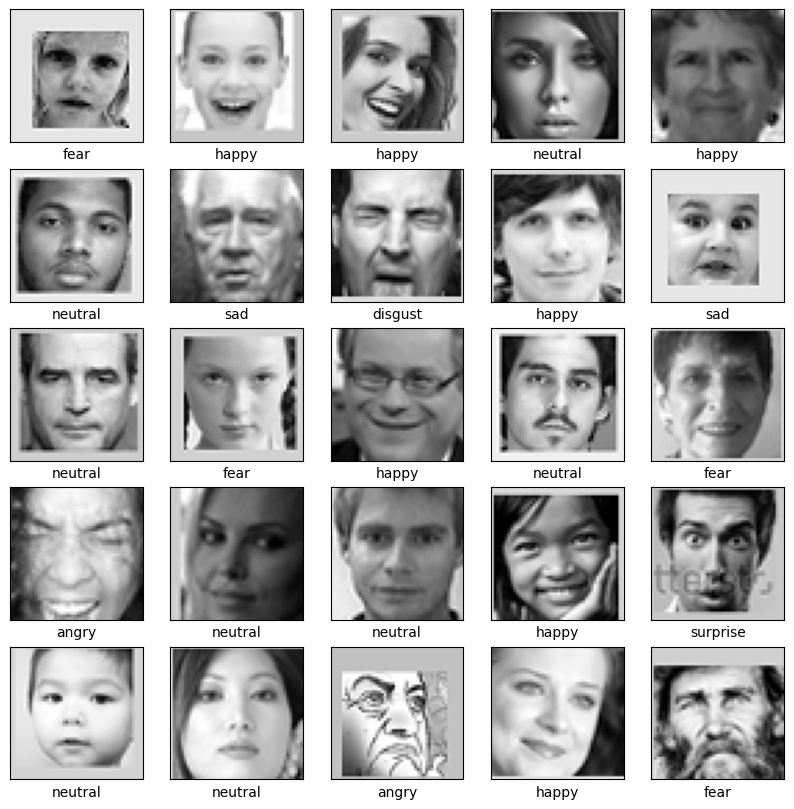

In [ ]:
# Visual check of the model's prediction
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap='gray')
    plt.xlabel( EMOTIONS[ predictions[i] ] )
plt.show()

## Other less efficient models and comparison
All the following models accuracy is not as great as the first conventionnal one. It is other models made for comparaison between models.

In [ ]:
# SVM model train on a small but equally balance data set.
# Accuracy is the worst of all SVM model tested (35%).
'''
training_images = smaller_images_train
training_labels = smaller_labels_train
test_images     = images_val
test_labels     = labels_val    #for calculating the accurancy

# Flatten the images
training_images_flattened = training_images.reshape(training_images.shape[0], -1)

# Make the model and train it
poly_kernel_svm_clf = Pipeline([
  ("scaler", StandardScaler()),
  ("svm_clf", SVC(kernel = "poly", degree = 3, coef0 = 1, C = 5))
])
poly_kernel_svm_clf.fit(training_images_flattened, training_labels)

# Make predictions on the test set
test_images_flattened = test_images.reshape(test_images.shape[0], -1)
ml_predictions = poly_kernel_svm_clf.predict(test_images_flattened)

# Display classification report
report = classification_report(test_labels, ml_predictions)
print(report) #accuracy = 0.35
'''

              precision    recall  f1-score   support

           0       0.28      0.36      0.31       226
           1       0.06      0.48      0.11        23
           2       0.23      0.24      0.23       203
           3       0.70      0.45      0.55       546
           4       0.17      0.21      0.18       185
           5       0.38      0.50      0.43       168
           6       0.42      0.26      0.32       375

    accuracy                           0.35      1726
   macro avg       0.32      0.36      0.30      1726
weighted avg       0.43      0.35      0.37      1726



In [ ]:
# The model is a SVM, trained on provided set and test on an equally balanced set.
# It is without data augmentation and HOG feature.
# Accuracy is +14% better than the previous one

'''
training_images = images_train
training_labels = labels_train
test_images     = smaller_images_train
test_labels     = smaller_labels_train    #for calculating the accurancy

# Flatten the images
training_images_flattened = training_images.reshape(training_images.shape[0], -1)

# Make the model and train it
poly_kernel_svm_clf = Pipeline([
  ("scaler", StandardScaler()),
  ("svm_clf", SVC(kernel = "poly", degree = 3, coef0 = 1, C = 5))
])
poly_kernel_svm_clf.fit(training_images_flattened, training_labels)

# Make predictions on the test set
test_images_flattened = test_images.reshape(test_images.shape[0], -1)
ml_predictions = poly_kernel_svm_clf.predict(test_images_flattened)

# Display classification report
report = classification_report(test_labels, ml_predictions)
print(report) #accuracy = 0.49
'''

              precision    recall  f1-score   support

           0       0.34      0.36      0.35       100
           1       0.95      0.36      0.52       100
           2       0.45      0.39      0.42       100
           3       0.51      0.78      0.62       100
           4       0.36      0.29      0.32       100
           5       0.73      0.73      0.73       100
           6       0.39      0.53      0.45       100

    accuracy                           0.49       700
   macro avg       0.53      0.49      0.49       700
weighted avg       0.53      0.49      0.49       700



In [ ]:
# The same SVM model but test on imbalanced test set.
# The accuarcy is a bit better than the previous model, +4%.

training_images = images_train
training_labels = labels_train
test_images     = images_test
test_labels     = labels_test    #for calculating the accurancy

# Flatten the images
training_images_flattened = training_images.reshape(training_images.shape[0], -1)

# Make the model and train it
poly_kernel_svm_clf = Pipeline([
  ("scaler", StandardScaler()),
  ("svm_clf", SVC(kernel = "poly", degree = 3, coef0 = 1, C = 1))
])
poly_kernel_svm_clf.fit(training_images_flattened, training_labels)

# Make predictions on the test set
test_images_flattened = test_images.reshape(test_images.shape[0], -1)
ml_predictions = poly_kernel_svm_clf.predict(test_images_flattened)

# Display classification report
report = classification_report(test_labels, ml_predictions)
print(report) #accuracy = 0.53

              precision    recall  f1-score   support

           0       0.39      0.38      0.38       206
           1       0.62      0.28      0.39        46
           2       0.36      0.28      0.31       171
           3       0.70      0.78      0.74       463
           4       0.38      0.30      0.34       151
           5       0.62      0.58      0.60       165
           6       0.45      0.53      0.49       291

    accuracy                           0.53      1493
   macro avg       0.50      0.45      0.46      1493
weighted avg       0.52      0.53      0.52      1493



In [ ]:
# Same SVM model with HOG feature and data augmentation
# Acuuracy is +8% than the previous one

all_images = []
for image in images_train:
    augmented_images = sequential.augment_images([image])
    all_images.extend(augmented_images)
all_images = np.array(all_images)

all_images = np.concatenate((images_train, all_images), axis = 0)
all_labels_train = np.concatenate((labels_train, labels_train), axis = 0)

# Extract HOG features for training images
hog_features_train = [extract_hog_features(image) for image in all_images]
# Extract HOG features for test images
hog_features_test = [extract_hog_features(image) for image in images_test]

poly_kernel_svm_clf = Pipeline([
  ("scaler", StandardScaler()),
  ("svm_clf", SVC(kernel = "poly", degree = 4, coef0 = 1, C = 5))
])
poly_kernel_svm_clf.fit(hog_features_train, all_labels_train)

predictions = poly_kernel_svm_clf.predict(hog_features_test)

# Evaluate the model's performance
accuracy = accuracy_score(labels_test, predictions)
report = classification_report(labels_test, predictions)
confusion = confusion_matrix(labels_test, predictions)

print("Accuracy:", accuracy) #0.61
print("Classification Report:\n", report)
print("Confusion Matrix:\n", confusion)

Accuracy: 0.608841259209645
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.50      0.48       206
           1       1.00      0.43      0.61        46
           2       0.39      0.34      0.36       171
           3       0.79      0.84      0.81       463
           4       0.39      0.28      0.33       151
           5       0.63      0.65      0.64       165
           6       0.57      0.65      0.61       291

    accuracy                           0.61      1493
   macro avg       0.61      0.53      0.55      1493
weighted avg       0.60      0.61      0.60      1493

Confusion Matrix:
 [[103   0  26  14  19   6  38]
 [ 13  20   2   6   2   1   2]
 [ 27   0  58  15  18  29  24]
 [ 19   0   8 389   5   8  34]
 [ 29   0  20  15  43   8  36]
 [  8   0  19  19   6 107   6]
 [ 23   0  15  36  17  11 189]]


In [ ]:
# Same SVM model without HOG and data augmentation, but training on the bigger MIX data set
# Accuracy is the same as with the provided smaller images_train set.

training_images = images_train_mix
training_labels = labels_train_mix
test_images     = images_test
test_labels     = labels_test    #for calculating the accurancy

# Flatten the images
training_images_flattened = training_images.reshape(training_images.shape[0], -1)

# Make the model and train it
poly_kernel_svm_clf = Pipeline([
  ("scaler", StandardScaler()),
  ("svm_clf", SVC(kernel = "poly", degree = 3, coef0 = 1, C = 1))
])
poly_kernel_svm_clf.fit(training_images_flattened, training_labels)

# Make predictions on the test set
test_images_flattened = test_images.reshape(test_images.shape[0], -1)
ml_predictions = poly_kernel_svm_clf.predict(test_images_flattened)

# Display classification report
report = classification_report(test_labels, ml_predictions)
print(report) #accuracy = 0.53

              precision    recall  f1-score   support

           0       0.42      0.40      0.41       206
           1       0.72      0.28      0.41        46
           2       0.34      0.29      0.31       171
           3       0.69      0.79      0.74       463
           4       0.33      0.27      0.30       151
           5       0.64      0.58      0.61       165
           6       0.46      0.50      0.48       291

    accuracy                           0.53      1493
   macro avg       0.51      0.45      0.46      1493
weighted avg       0.53      0.53      0.52      1493



In [ ]:
# KNN model (n=3)

training_images = images_train
training_labels = labels_train
test_images     = images_test
test_labels     = labels_test

training_images_flattened = training_images.reshape(training_images.shape[0], -1)
test_images_flattened = test_images.reshape(test_images.shape[0], -1)

# Prétraitement des données
scaler = StandardScaler()
scaler.fit(training_images_flattened)  # Ajuster le scaler aux données d'entraînement

training_images_scaled = scaler.transform(training_images_flattened)
test_images_scaled = scaler.transform(test_images_flattened)  # Mettre à l'échelle les données de test de la même manière

# Création et entraînement du modèle KNN
knn = KNeighborsClassifier(n_neighbors=3)  # Choisissez le nombre de voisins (k) approprié
knn.fit(training_images_scaled, training_labels)

# Prédictions sur l'ensemble de test
predictions = knn.predict(test_images_scaled)

# Évaluation du modèle
report = classification_report(test_labels, predictions)
print(report)  # accuracy: 0.37

              precision    recall  f1-score   support

           0       0.29      0.35      0.32       159
           1       0.12      0.17      0.14        18
           2       0.26      0.27      0.26       145
           3       0.48      0.58      0.53       326
           4       0.28      0.12      0.17       122
           5       0.54      0.22      0.31       126
           6       0.34      0.39      0.36       209

    accuracy                           0.37      1105
   macro avg       0.33      0.30      0.30      1105
weighted avg       0.38      0.37      0.36      1105



In [ ]:
# Random forest (n=500)

training_images = images_train
training_labels = labels_train
test_images     = images_test
test_labels     = labels_test

training_images_flattened = training_images.reshape(training_images.shape[0], -1)
test_images_flattened = test_images.reshape(test_images.shape[0], -1)

# Création et entraînement du modèle Random Forest
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(training_images_flattened, training_labels)

# Prédictions sur l'ensemble de test
predictions = rf.predict(test_images_flattened)

# Évaluation du modèle
report = classification_report(test_labels, predictions)
print(report)  # accuracy: 0.50

              precision    recall  f1-score   support

           0       0.46      0.27      0.34       124
           1       1.00      0.18      0.30        28
           2       0.58      0.27      0.37       112
           3       0.51      0.84      0.63       266
           4       0.33      0.07      0.11       105
           5       0.73      0.52      0.61       100
           6       0.44      0.59      0.51       220

    accuracy                           0.50       955
   macro avg       0.58      0.39      0.41       955
weighted avg       0.51      0.50      0.46       955



# Notes and comparison on the Conventional ML Model

For the final model, the SVM Classifier model with a kernel, HOG features, data augmentation and a bigger training set was selected because it has the best accuracy.

By testing, we saw that a bigger training set does not mean  better score, but that HOG feature and data augmentation are powerful tools to improve accuracy.
However, as tested, training the model on a smaller but balanced set was worst, especially because test set were imbalance too.

In addition to the final model, I also tried a KNN model, with k=3. This performed fairly poorly (accuracy 37%). I also tried a random forest model (n=500) that perform better but not as good as the SVM one, the accuracy was 50%.

# Deep Learning Model

The final model that produced the best-performing predictions for the Kaggle submission (accuracy 67% on the private test) was a fully connected CNN model with 14 layers.  The input was the mix set made from the provided one and the one I made, that had been preprocessed with data augmentation.

In [ ]:
# Data augmentation
dataGen = ImageDataGenerator(
    # rescale=1./255,
    rotation_range=10,
    zoom_range=[0.9, 1.3],
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Same model as the CNN model 2, but trained on a bigger data set
# accuracy is 1% better or similar

training_images = images_train_mix
training_labels = labels_train_mix
val_images      = images_val
val_labels      = labels_val
test_images     = images_test
test_labels     = labels_test

training_images = training_images.reshape(-1, 48, 48, 1)
val_images = val_images.reshape(-1, 48, 48, 1)

# Define a simple Convolutional Neural Network (CNN) model
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.1),

    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.1),

    keras.layers.Conv2D(256, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.1),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'), #sigmoid and epochs=40 -> 0.62
    keras.layers.Dropout(0.2),

    keras.layers.Dense(7, activation='softmax')  # 7 classes for emotions
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(dataGen.flow(training_images, training_labels, batch_size=32), epochs=20, validation_data=(val_images, val_labels))

model.save('/content/drive/My Drive/Colab Notebooks/Project/model/CNN_V2_AUG_MIX_trained_model_2.h5')

# Generate predictions on the test set
predictions = model.predict(test_images)

# Evaluate the model on the test set, usefull ? => to know overfitting
test_loss, test_accuracy = model.evaluate(training_images, training_labels)
print("Test Accuracy:", test_accuracy)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Display classification report
report = classification_report(test_labels, predicted_labels)
print(report) #accuracy = 0.64

Epoch 1/20
411/411 [==============================] - 135s 323ms/step - loss: 1.7751 - accuracy: 0.2836 - val_loss: 1.6047 - val_accuracy: 0.4100
Epoch 2/20
411/411 [==============================] - 131s 320ms/step - loss: 1.5885 - accuracy: 0.3920 - val_loss: 1.3796 - val_accuracy: 0.4973
Epoch 3/20
411/411 [==============================] - 132s 322ms/step - loss: 1.4554 - accuracy: 0.4495 - val_loss: 1.2830 - val_accuracy: 0.5257
Epoch 4/20
411/411 [==============================] - 130s 316ms/step - loss: 1.3625 - accuracy: 0.4842 - val_loss: 1.1556 - val_accuracy: 0.5766
Epoch 5/20
411/411 [==============================] - 133s 324ms/step - loss: 1.2967 - accuracy: 0.5089 - val_loss: 1.1174 - val_accuracy: 0.5916
Epoch 6/20
411/411 [==============================] - 132s 321ms/step - loss: 1.2434 - accuracy: 0.5289 - val_loss: 1.0826 - val_accuracy: 0.6040
Epoch 7/20
411/411 [==============================] - 132s 321ms/step - loss: 1.2132 - accuracy: 0.5407 - val_loss: 1.0959 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


411/411 [==============================] - 33s 80ms/step - loss: 0.7971 - accuracy: 0.7056
Test Accuracy: 0.7056362628936768
              precision    recall  f1-score   support

           0       0.56      0.57      0.56       206
           1       0.71      0.33      0.45        46
           2       0.42      0.47      0.45       171
           3       0.86      0.87      0.86       463
           4       0.40      0.35      0.37       151
           5       0.69      0.68      0.69       165
           6       0.59      0.61      0.60       291

    accuracy                           0.64      1493
   macro avg       0.60      0.55      0.57      1493
weighted avg       0.64      0.64      0.64      1493



37/37 [==============================] - 3s 72ms/step


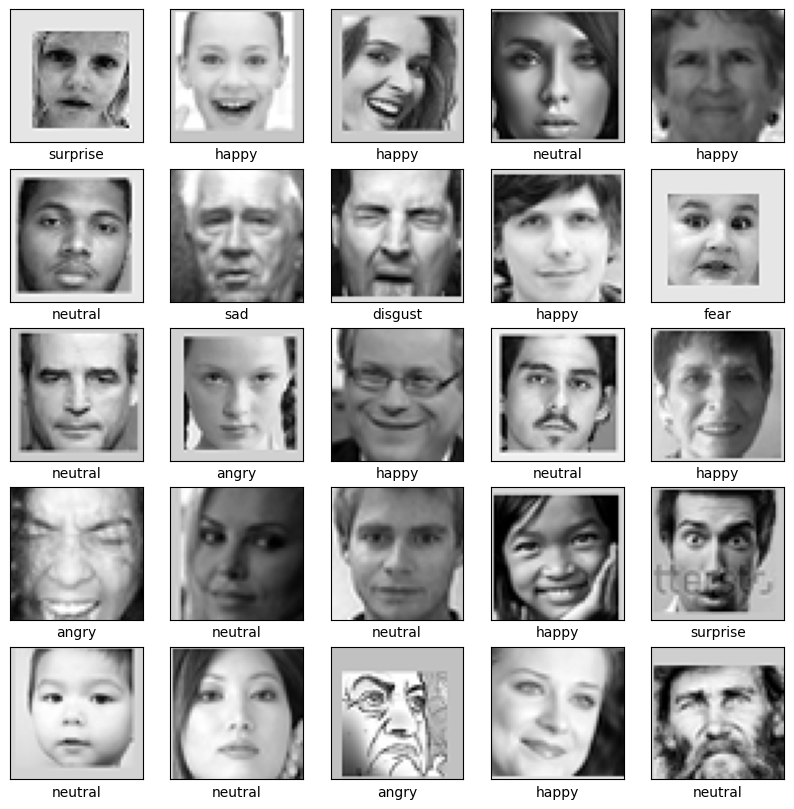

In [ ]:
test_images = images_test_private

# Load the saved model
loaded_model = load_model('/content/drive/My Drive/Colab Notebooks/Project/model/CNN_V2_AUG_MIX_trained_model_2.h5')

# Generate predictions on the test set
predictions = loaded_model.predict(test_images)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap='gray')
    plt.xlabel( EMOTIONS[ predicted_labels[i] ] )
plt.show()

# Write result in the csv file
pred_file_path = join(dataset_directory, '48040665-deep-private.csv')
pred_file = pd.read_csv(pred_file_path)
pred_file['Predictions'] = predicted_labels
pred_file.to_csv(pred_file_path, index=False)

## Other less efficient models and comparison
The following model and parameter are not as good as the first one, but were made for comparison.


In [ ]:
# CNN 1 model training on equitable data
# Worst accuracy of any CNN models, 42%
'''
# Define a simple Convolutional Neural Network (CNN) model
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),

    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(7, activation='softmax')  # 7 classes for emotions
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(smaller_images_train, smaller_labels_train, epochs=10, validation_data=(images_val, labels_val))

# Generate predictions on the test set
predictions = model.predict(images_train)

# Evaluate the model on the test set, usefull ??
test_loss, test_accuracy = model.evaluate(images_train, labels_train)
print("Test Accuracy:", test_accuracy)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Display classification report
report = classification_report(labels_train, predicted_labels)
print(report) #accuracy = 0.42
'''


Epoch 1/10
22/22 [==============================] - 10s 23ms/step - loss: 2.0396 - accuracy: 0.1471 - val_loss: 2.0604 - val_accuracy: 0.1251
Epoch 2/10
22/22 [==============================] - 0s 12ms/step - loss: 1.8867 - accuracy: 0.2614 - val_loss: 1.9331 - val_accuracy: 0.2503
Epoch 3/10
22/22 [==============================] - 0s 10ms/step - loss: 1.7823 - accuracy: 0.3486 - val_loss: 1.9537 - val_accuracy: 0.1727
Epoch 4/10
22/22 [==============================] - 0s 10ms/step - loss: 1.6227 - accuracy: 0.4214 - val_loss: 1.8494 - val_accuracy: 0.2717
Epoch 5/10
22/22 [==============================] - 0s 11ms/step - loss: 1.4387 - accuracy: 0.5271 - val_loss: 1.6885 - val_accuracy: 0.3864
Epoch 6/10
22/22 [==============================] - 0s 11ms/step - loss: 1.2679 - accuracy: 0.5743 - val_loss: 1.7522 - val_accuracy: 0.3389
Epoch 7/10
22/22 [==============================] - 0s 11ms/step - loss: 1.1293 - accuracy: 0.6329 - val_loss: 1.6538 - val_accuracy: 0.4038
Epoch 8/10
2

In [ ]:
# Same CNN model 1 but training on provided traning data
# Accuracy is 2% better than the previous one

model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(7, activation='softmax')  # 7 classes for emotions
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(images_train, labels_train, epochs=10, validation_data=(images_val, labels_val))

# Generate predictions on the test set
predictions = model.predict(images_test)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Display classification report
report = classification_report(labels_test, predicted_labels)
print(report) #accuracy = 0.44

In [ ]:
# CNN model 2, training on provided traning data
# Accuracy is +16% better than CNN 1 model on the same traning data

training_images = images_train
training_labels = labels_train
val_images      = images_val
val_labels      = labels_val
test_images     = images_test
test_labels     = labels_test

# Define a simple Convolutional Neural Network (CNN) model
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.1),

    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.1),

    keras.layers.Conv2D(256, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.1),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.2),

    keras.layers.Dense(7, activation='softmax')  # 7 classes for emotions
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(training_images, training_labels, epochs=10, validation_data=(val_images, val_labels))

# Generate predictions on the test set
predictions = model.predict(test_images)

# Evaluate the model on the test set, usefull ? => to know overfitting
test_loss, test_accuracy = model.evaluate(training_images, training_labels)
print("Test Accuracy:", test_accuracy)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Display classification report
report = classification_report(test_labels, predicted_labels)
print(report) #accuracy = 0.60

Epoch 1/10
138/138 [==============================] - 5s 13ms/step - loss: 1.7764 - accuracy: 0.2957 - val_loss: 1.7841 - val_accuracy: 0.3172
Epoch 2/10
138/138 [==============================] - 1s 10ms/step - loss: 1.6518 - accuracy: 0.3580 - val_loss: 1.5205 - val_accuracy: 0.4576
Epoch 3/10
138/138 [==============================] - 2s 12ms/step - loss: 1.4339 - accuracy: 0.4658 - val_loss: 1.3791 - val_accuracy: 0.5221
Epoch 4/10
138/138 [==============================] - 1s 10ms/step - loss: 1.3044 - accuracy: 0.5179 - val_loss: 1.3067 - val_accuracy: 0.5424
Epoch 5/10
138/138 [==============================] - 2s 12ms/step - loss: 1.1862 - accuracy: 0.5541 - val_loss: 1.1750 - val_accuracy: 0.5706
Epoch 6/10
138/138 [==============================] - 1s 11ms/step - loss: 1.0846 - accuracy: 0.6033 - val_loss: 1.1253 - val_accuracy: 0.5938
Epoch 7/10
138/138 [==============================] - 2s 12ms/step - loss: 0.9834 - accuracy: 0.6406 - val_loss: 1.1034 - val_accuracy: 0.5974

In [ ]:
# Same model but with data augmentation
# Accuracy is 3% better

training_images = images_train
training_labels = labels_train
val_images      = images_val
val_labels      = labels_val
test_images     = images_test
test_labels     = labels_test

training_images = training_images.reshape(-1, 48, 48, 1)
val_images = val_images.reshape(-1, 48, 48, 1)

# Define a simple Convolutional Neural Network (CNN) model
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),

    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.1),

    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.1),

    keras.layers.Conv2D(256, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.1),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'), #sigmoid and epochs=40 -> 0.62
    keras.layers.Dropout(0.2),

    keras.layers.Dense(7, activation='softmax')  # 7 classes for emotions
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(dataGen.flow(training_images, training_labels, batch_size=32), epochs=20, validation_data=(val_images, val_labels))

# Generate predictions on the test set
predictions = model.predict(test_images)

# Evaluate the model on the test set, usefull ? => to know overfitting
test_loss, test_accuracy = model.evaluate(training_images, training_labels)
print("Test Accuracy:", test_accuracy)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Display classification report
report = classification_report(test_labels, predicted_labels)
print(report) #accuracy = 0.63

In [ ]:
# Same model but with L2 regulation, the model did not learn, acucracy of 37%
training_images = images_train
training_labels = labels_train
val_images      = images_val
val_labels      = labels_val
test_images     = images_test
test_labels     = labels_test

from keras.regularizers import l2

# Define a simple Convolutional Neural Network (CNN) model with L2 regularization
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1), kernel_regularizer=l2(0.01)),

    keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.1),

    keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.1),

    keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.1),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    keras.layers.Dropout(0.2),

    keras.layers.Dense(7, activation='softmax')  # 7 classes for emotions
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(dataGen.flow(training_images, training_labels, batch_size=32), epochs=20, validation_data=(val_images, val_labels))

# Generate predictions on the test set
predictions = model.predict(test_images)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print("Test Accuracy:", test_accuracy)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Display classification report
report = classification_report(test_labels, predicted_labels)
print(report)

# Notes on the Deep Learning Model

The final model was a CNN with 14 layers, data augmentation and trained on a bigger set, with an accuracy of 67%.

In addition to the final model, I also tried a CNN with less layer. This performed worst. I also tried a L2 regulation but the model did not learn.

# Discussion of Model Performance and Implementation

Comparing my final conventional ML and deep learning models, the deep learning one performed better by 5% on the public test set.  The deep learning model ranked #10 out of 5 submissions on the public test and #7 on private test out of 2 submission, over 32 candidates.
The top-performing system having 67% accuracy, and a majority class baseline having 59% accuracy.

The deep learning model had a better accuracy for my case.

Next step is to tried Transfert learning by using a pre-trained model. I will then modify the last layers.